Deep Learning (Model Bi-LSTM with Word2Vec )
-----------------

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf
import sklearn
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, MaxPooling1D, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

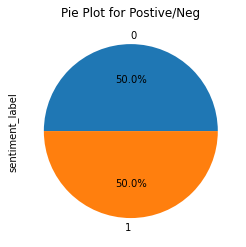

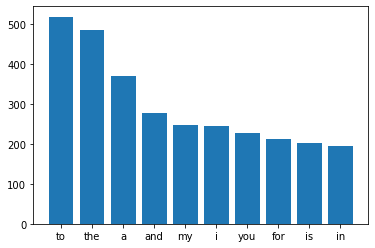

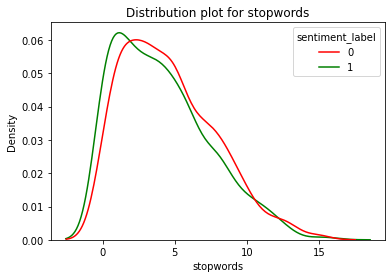

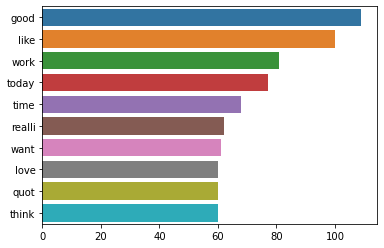

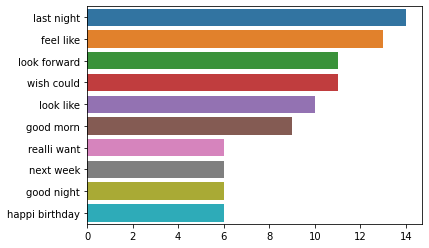

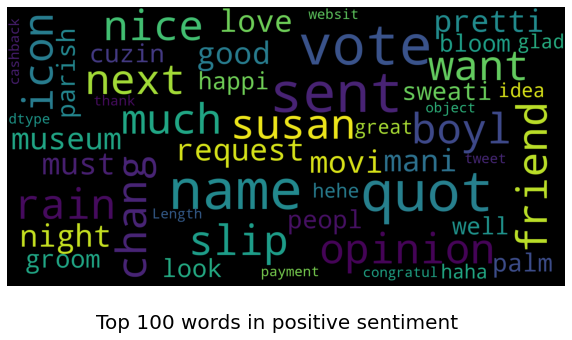

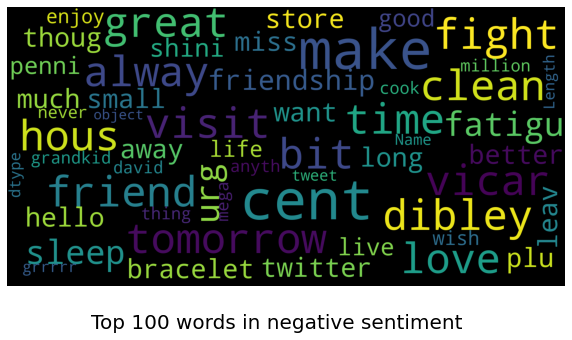

In [2]:
%run EDA.ipynb

#### Keras Tokenizer

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_preprocess.tweet)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 2968


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_preprocess['tweet'], 
                                                    df_preprocess['sentiment_label'], test_size=0.25, 
                                                    random_state=42)

In [5]:
EMBEDDING_DIM = 300

# Creating Word2Vec train dataset.
train_data = list(map(lambda x: x.split(), X_train))

#### Create the Word2Vec Embedding

In [6]:
word2vec_model = Word2Vec(train_data,
                 vector_size=EMBEDDING_DIM,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 278


In [7]:
# Define the model input length
max_sequence_length = 30

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_sequence_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=max_sequence_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1200, 30)
X_test.shape : (400, 30)


In [8]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (2968, 300)


In [9]:
batch_size = 512
epoch = 6

In [10]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=max_sequence_length,
                                          trainable=False)

In [11]:
es=EarlyStopping(monitor='val_loss', min_delta=0, mode='min', verbose=1, patience=5)

reduce_lr = ReduceLROnPlateau(factor=0.1, min_delta=0, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

### Create the Bidirectional LSTM Model

In [12]:
inputs = tf.keras.Input(shape=(max_sequence_length,), dtype="int32")

x = embedding_layer(inputs)
x = SpatialDropout1D(0.2)(x)

# Bidirectional LSTM 
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

2022-04-13 18:14:24.026950: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch,
                    validation_data=(X_test, y_test), callbacks= [es, reduce_lr])

Epoch 1/6
3/3 [==============================] - 7s 841ms/step - loss: 0.6934 - accuracy: 0.4567 - val_loss: 0.6932 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 2/6
3/3 [==============================] - 2s 570ms/step - loss: 0.6931 - accuracy: 0.5150 - val_loss: 0.6933 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 3/6
3/3 [==============================] - 2s 553ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6934 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 4/6
3/3 [==============================] - 2s 568ms/step - loss: 0.6929 - accuracy: 0.5075 - val_loss: 0.6934 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 5/6
3/3 [==============================] - 2s 525ms/step - loss: 0.6929 - accuracy: 0.5067 - val_loss: 0.6933 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 6/6
3/3 [==============================] - 2s 550ms/step - loss: 0.6931 - accuracy: 0.5083 - val_loss: 0.6933 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 6: early stopping


### Lets plot the learning curves

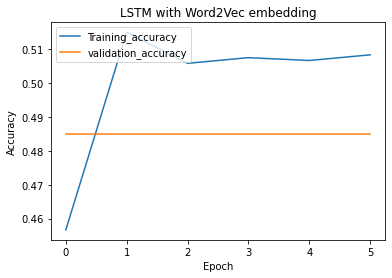

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('LSTM with Word2Vec embedding')
plt.xlabel('Epoch')
plt.legend(['Training_accuracy', 'validation_accuracy'], loc='upper left');

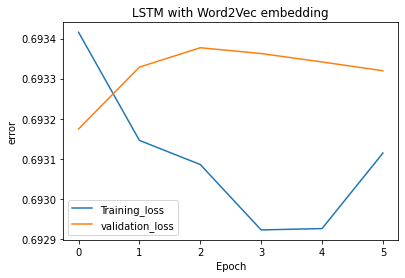

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('error')
plt.title('LSTM with Word2Vec embedding')
plt.xlabel('Epoch')
plt.legend(['Training_loss', 'validation_loss'], loc='lower left');

In [17]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

13/13 [==============================] - 0s 20ms/step - loss: 0.6933 - accuracy: 0.4850
Accuracy: 48.50%
